In [1]:
# Here we calculate the mass gap in the following ways (m1 = heaviest still):
# Usual for n = 2. n >= 3, take average of heaviest two satellites
import astropy.io.fits as fits
import numpy as np
from astropy.table import unique,Table,setdiff,hstack,join
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

MassGapData = Table.read('/suphys/fscu5535/python_scripts/mod_data/ImprovedDataMassGapMethod3.fits',memmap=True)
MassGapData.info()
print(MassGapData)

<Table length=2716>
    name     dtype     unit      class     n_bad
----------- ------- --------- ------------ -----
     CATAID   int64           MaskedColumn     0
    GroupID   int32           MaskedColumn     0
RankIterCen   int16           MaskedColumn     0
   logmstar float32 dex(Msun)       Column     0
 LAMBDAR_RE float64                 Column  2076
 CATAID GroupID RankIterCen  logmstar     LAMBDAR_RE    
                            dex(Msun)                   
------- ------- ----------- --------- ------------------
   6837  203007           1   9.82991                nan
   6838  203007           2 9.3911085                nan
   7203  203039           2 10.380958                nan
   7206  203039           1 10.410899 0.5493758320808411
   7289  203048           1 11.081309 0.0719321072101593
   7293  203048           2  9.731596                nan
    ...     ...         ...       ...                ...
3634416  101283           4  9.093014                nan
3634544  1

In [8]:
# group data by GroupID and then sort by logmstar
MassGapDataGrouped = MassGapData.group_by('GroupID')
MassGapDataGrouped.sort(['GroupID','logmstar'])
print(MassGapDataGrouped.groups[10])

CATAID GroupID RankIterCen  logmstar      LAMBDAR_RE    
                           dex(Msun)                    
------ ------- ----------- --------- -------------------
365386  100095           7   9.39212                 nan
365384  100095          10   9.46128                 nan
514226  100095           4  9.472072                 nan
388529  100095          13 9.5968485                 nan
514227  100095           3  9.647426                 nan
365383  100095          14  9.786331                 nan
   ...     ...         ...       ...                 ...
419549  100095          11 10.342318  0.5967241525650024
419574  100095          12 10.371602                 nan
388510  100095          17 10.421163                 nan
419548  100095           9 10.605533                 nan
514218  100095           6 10.803468  0.3339168131351471
388513  100095          16 10.839848  0.2574252486228943
514214  100095           1 11.141912 0.12003781646490097
Length = 17 rows


In [7]:
# calculate the mean for just the heaviest two satellites. Manually checked these and they are correct
print("Mean is:",np.mean(MassGapDataGrouped.groups[10]['logmstar'][-3:-1]))

Mean is: 10.821657


In [11]:
# Now calculate this for every group for n >= 3. For n = 2 use old method
satelliteMean = list()
groupID = list()
nonPairCount = 0
# for galaxy pairs, just use m2 = satellite. For n >=3, use mean of heaviest two galaxies
for i in range(len(MassGapDataGrouped.groups)):
    if len(MassGapDataGrouped.groups[i]['logmstar']) == 2:
        satelliteMean.append(MassGapDataGrouped.groups[i]['logmstar'][-2])
        groupID.append(MassGapDataGrouped.groups[i]['GroupID'][0])
    else:
        satelliteMean.append(np.mean(MassGapDataGrouped.groups[i]['logmstar'][-3:-1]))
        groupID.append(MassGapDataGrouped.groups[i]['GroupID'][0])
        nonPairCount += 1

    
print(len(satelliteMean),"group satellite means calculated")
print(nonPairCount,"of these are not galaxy pairs")
print(len(groupID),"groups in total")

MeanTable = Table()
MeanTable['GroupID'] = groupID
MeanTable['IntermediateMean'] = satelliteMean

598 group satellite means calculated
307 of these are not galaxy pairs
598 groups in total


In [13]:
# Now check that this is ok
print(MassGapDataGrouped.groups[0])

print("Mean:",satelliteMean[0])
print((10.834722+10.628587)/2)

CATAID GroupID RankIterCen  logmstar      LAMBDAR_RE    
                           dex(Msun)                    
------ ------- ----------- --------- -------------------
372163  100006          17  8.714643                 nan
372222  100006          48  8.915278                 nan
372185  100006          32  8.935463                 nan
372164  100006           6  9.201263                 nan
372221  100006          40  9.235959                 nan
372189  100006          28  9.351252                 nan
   ...     ...         ...       ...                 ...
372171  100006          44 10.520071                 nan
372177  100006          43 10.557999                 nan
372176  100006          51 10.572487                 nan
372126  100006          13 10.587907                 nan
376633  100006          54 10.628587                 nan
301599  100006          16 10.834722                 nan
372123  100006           1 11.250554 0.11300508677959442
Length = 54 rows
Mean: 10.73165

Text(0, 0.5, 'Frequency')

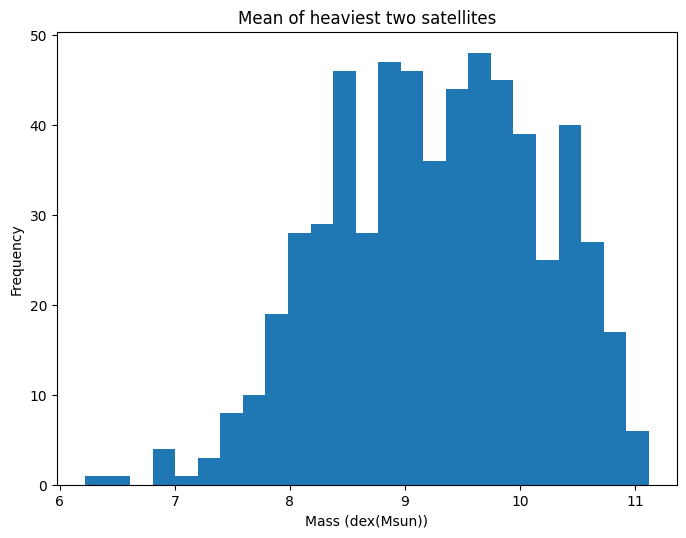

In [14]:
# Plot distributions to see if there's any outliers
plt.figure(figsize=(8, 6), dpi=100)
MeanPlot = plt.hist(satelliteMean,bins=25)
plt.title("Mean of heaviest two satellites")
plt.xlabel("Mass (dex(Msun))")
plt.ylabel("Frequency")

In [17]:
# So the distribution is fairly normal. The low mean/median satellite masses are probably
# galaxy pairs where m2 is low. Now read in latest massgap data with MassA log(MassA)/m1 etc and join
combinedData = Table.read('/suphys/fscu5535/python_scripts/mod_data/massGaps3.2.1.fits',memmap=True)
NewCombinedData = join(combinedData,MeanTable,keys='GroupID',join_type='left')
NewCombinedData.info()

<Table length=552>
      name        dtype   unit     class     n_bad
---------------- ------- ------ ------------ -----
         GroupID   int32        MaskedColumn     0
       m1_CATAID   int64        MaskedColumn     0
       m2_CATAID   int64        MaskedColumn     0
              m1 float32              Column     0
              m2 float32              Column     0
           m1-m2 float32              Column     0
   m1_LAMBDAR_RE float64              Column   120
            Nfof   int16        MaskedColumn     0
           MassA float32 Msun/h       Column     0
   log(MassA)/m1 float64              Column     0
         SatMean float32              Column     0
       SatMedian float32              Column     0
      m1-SatMean float32              Column     0
    m1-SatMedian float32              Column     0
      log(MassA) float64              Column     0
IntermediateMean float32              Column     0


In [18]:
# Check data, rename mass gap column and then write to file
print(NewCombinedData[0])
NewCombinedData.write('/suphys/fscu5535/python_scripts/mod_data/massGaps4.0.fits',overwrite = True)

GroupID m1_CATAID m2_CATAID     m1        m2      m1-m2       m1_LAMBDAR_RE    Nfof       MassA         log(MassA)/m1    SatMean  SatMedian m1-SatMean m1-SatMedian     log(MassA)     IntermediateMean
                                                                                          Msun/h                                                                                                       
------- --------- --------- --------- --------- ---------- ------------------- ---- ----------------- ------------------ -------- --------- ---------- ------------ ------------------ ----------------
 100006    372123    301599 11.250554 10.834722 0.41583252 0.11300508677959442   54 118932000000000.0 1.2510760456092813 9.887333  9.826758  1.3632212    1.4237957 14.075298715297198        10.731654


In [19]:
# Data looks good. Now recalculate the mass gap using m2 = {SatMean, SatMedian} and then compare all 3
latestMassGaps = Table.read('/suphys/fscu5535/python_scripts/mod_data/massGaps4.0.fits',memmap=True)

massGapMean = list()

for i in range(len(latestMassGaps)):
    massGapMean.append(latestMassGaps[i]['m1'] - latestMassGaps[i]['IntermediateMean'])

# join with data and write to file
latestMassGaps['m1-IntMean'] = massGapMean
latestMassGaps.write('/suphys/fscu5535/python_scripts/mod_data/massGaps4.1.fits',overwrite=True)


In [25]:
# Changing columns around and checking that mass gaps calculated properly
Data = Table.read('/suphys/fscu5535/python_scripts/mod_data/massGaps4.1.fits',memmap=True)
Data.info()
Data.write('/suphys/fscu5535/python_scripts/mod_data/massGaps4.2.fits',overwrite=True)

print(Data[0])

<Table length=552>
      name        dtype   unit     class     n_bad
---------------- ------- ------ ------------ -----
         GroupID   int32        MaskedColumn     0
       m1_CATAID   int64        MaskedColumn     0
       m2_CATAID   int64        MaskedColumn     0
              m1 float32              Column     0
              m2 float32              Column     0
           m1-m2 float32              Column     0
   m1_LAMBDAR_RE float64              Column   120
            Nfof   int16        MaskedColumn     0
           MassA float32 Msun/h       Column     0
   log(MassA)/m1 float64              Column     0
         SatMean float32              Column     0
       SatMedian float32              Column     0
      m1-SatMean float32              Column     0
    m1-SatMedian float32              Column     0
      log(MassA) float64              Column     0
IntermediateMean float32              Column     0
      m1-IntMean float32              Column     0
GroupID m1_C

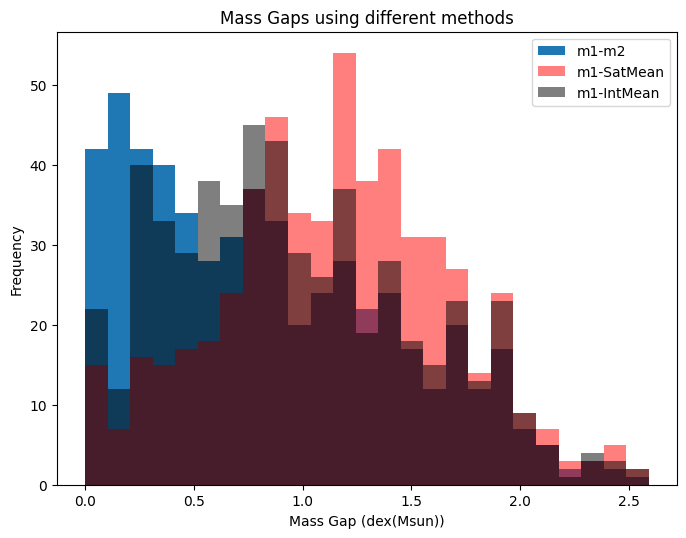

In [46]:
# Plot histograms
plt.figure(figsize=(8, 6), dpi=100)
massGapm2 = plt.hist(Data['m1-m2'],bins=25)
massGapSatMean = plt.hist(Data['m1-SatMean'],bins=25,color='r',alpha=0.5)
massGapIntMean = plt.hist(Data['m1-IntMean'],bins = 25, color = 'black', alpha=0.5)
plt.title("Mass Gaps using different methods")
plt.xlabel("Mass Gap (dex(Msun))")
plt.ylabel("Frequency")
plt.legend(['m1-m2','m1-SatMean','m1-IntMean'])

# Save figure to file
filename = "/suphys/fscu5535/python_scripts/figures/DifferentMassGapMethods.png"
plt.savefig(filename, bbox_inches='tight', pad_inches=0.3, dpi = 250)


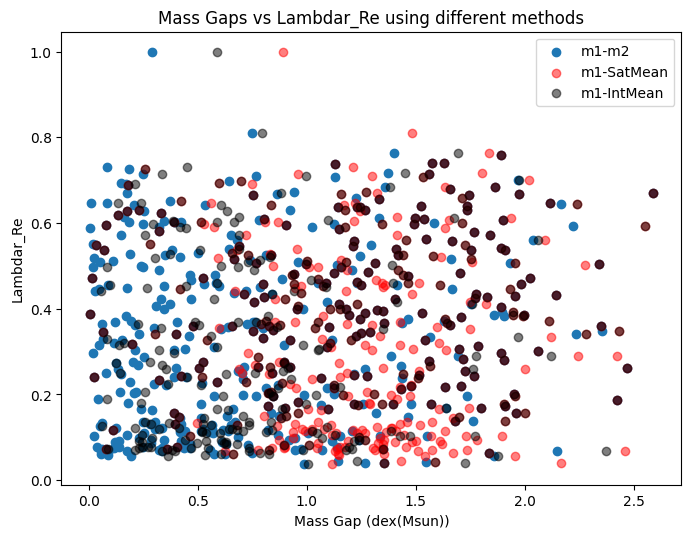

In [38]:
# Now plot mass gaps vs lambdar_re for both methods
plt.figure(figsize=(8, 6), dpi=100)
massGapm2Lambdar = plt.scatter(Data['m1-m2'],Data['m1_LAMBDAR_RE'])
massGapSatMeanLambdar = plt.scatter(Data['m1-SatMean'],Data['m1_LAMBDAR_RE'],color='r',alpha=0.5)
massGapIntMeanLambdar = plt.scatter(Data['m1-IntMean'],Data['m1_LAMBDAR_RE'],color='black', alpha=0.5)
plt.title("Mass Gaps vs Lambdar_Re using different methods")
plt.xlabel("Mass Gap (dex(Msun))")
plt.ylabel("Lambdar_Re")
plt.legend(['m1-m2','m1-SatMean','m1-IntMean'])

# Save figure to file
filename = "/suphys/fscu5535/python_scripts/figures/DifferentMassGapsvsLambdar.png"
plt.savefig(filename, bbox_inches='tight', pad_inches=0.3, dpi = 250)

Text(0, 0.5, 'log(MassA)/m1')

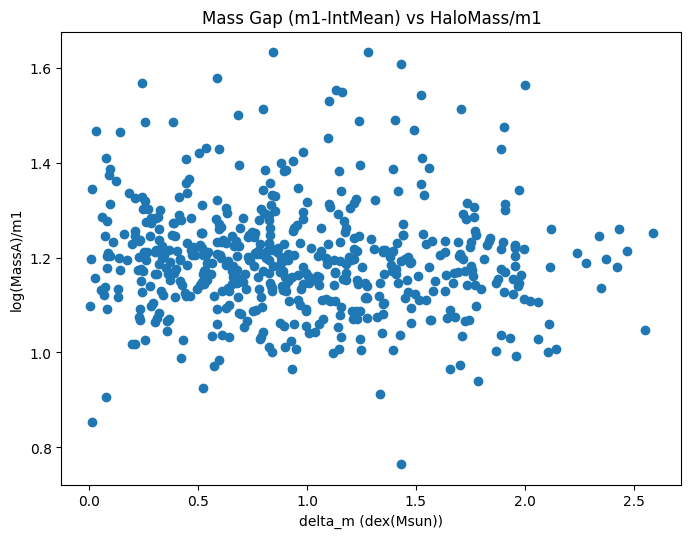

In [45]:
# Plot mass gaps against halomass/m1
plt.figure(figsize=(8, 6), dpi=100)
massGapHalomassToM1 = plt.scatter(Data['m1-IntMean'],Data['log(MassA)/m1'])
plt.title("Mass Gap (m1-IntMean) vs HaloMass/m1")
plt.xlabel("delta_m (dex(Msun))")
plt.ylabel("log(MassA)/m1")